In [24]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils_data
import scipy.io as sio
import matplotlib.pyplot as plt
from torchvision import transforms
import PIL

### Loading, processing, and splitting data
--------------------------------------

In [52]:
#%% Load Data
#
#   It may be beneficial to consider how to transform your data to obtain 
#   better performance.

mdict = sio.loadmat('data')
X = torch.from_numpy(mdict['X'].astype('float32').reshape((60000, 784))/255)
y = torch.from_numpy(mdict['y'].squeeze()).long()

# transform data into size of (60000,1,28,28)
X = X.reshape((-1,1,28,28))


50000 observations as training set, and 10000 as validation set

In [53]:
# split data into traning and validation
val_index = np.r_[0:60000:6]
indices = np.arange(60000)
train_index = np.where(indices%6!=0)[0]
X_train = X[train_index]
y_train = y[train_index]
X_val = X[val_index]
y_val = y[val_index]

Data augmentation:

In training set, get 10000 images to flip horizontally. Put them into training set as data augmentation.

In [54]:
# data augmentation
topil = transforms.ToPILImage()
totensor = transforms.ToTensor()

flip_index = np.r_[0:50000:5]
X_train_aug = X_train[flip_index]
# horizontal flip
for image in X_train_aug:
    image = topil(image)
    image = totensor(image.transpose(PIL.Image.FLIP_LEFT_RIGHT))
    image = image.reshape((1,1,28,28))
    X_train = torch.cat((X_train,image),0)
y_train = torch.cat((y_train,y_train[flip_index]),0)

Check if cuda is available

In [55]:
# move to cuda if available
if torch.cuda.is_available():
    device = torch.device("cuda")
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    X_val = X_val.to(device)
    y_val = y_val.to(device)

train_data = utils_data.TensorDataset(X_train, y_train)

Flip example:

Before flip


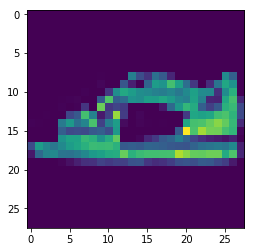

After flip


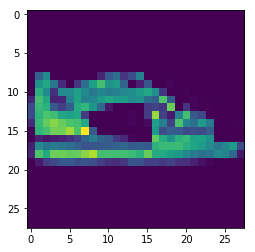

In [75]:
# before flip
print('Before flip')
plt.imshow(X_train[10][0])
plt.show()
# after flip
print('After flip')
plt.imshow(X_train[50002][0])
plt.show()

---------------------------------

### Defining model
------------------------------------------

In [84]:
#%% Define Neural Network Architecture
#
#   Modify your neural network here!

class Net(nn.Module):
    def __init__(self,b_n = True):
        super(Net, self).__init__()
        # if use batch normalization
        self.bn = b_n
        
        # Convolutional Layers
        # Conv2d(input_channels, output_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)
        
        # 1 input image channel, 10 output channels, 5x5 square convolution kernel
        self.conv1 = nn.Conv2d(1, 10, 5)
        
        # 10 input channels, 20 output channels, 5x5 square convolutional kernel
        self.conv2 = nn.Conv2d(10, 20, 5)
        
        # Max Pooling
        # MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)
        self.pool = nn.MaxPool2d(2)
        
        
        # An affine operation: y = Wx + b
        # Linear(input_features, output_features, bias=True)
        self.fc1 = nn.Linear(20 * 4 * 4, 80)
        self.fc2 = nn.Linear(80, 150)
        self.fc3 = nn.Linear(150, 10)
        self.drop = nn.Dropout(p=0.1)
        
        # batch normalization
        if self.bn==True:
            self.bn1 = nn.BatchNorm1d(20 * 4 * 4)
            self.bn2 = nn.BatchNorm1d(80)
            self.bn3 = nn.BatchNorm1d(150)

    def forward(self, x):
        # convolutional layer, ReLU activation, max pooling with (2, 2) window
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        x = x.view(-1, 20 * 4 * 4) # convert to flat feature vector
        
        # linear layer and ReLU activations
        if self.bn==False:
            x = F.relu(self.fc1(x))
            x = self.drop(x)
            x = F.relu(self.fc2(x))
            x = self.drop(x)
            x = self.fc3(x)
        else:
            x = F.relu(self.fc1(self.bn1(x)))
            x = self.drop(x)
            x = F.relu(self.fc2(self.bn2(x)))
            x = self.drop(x)
            x = self.fc3(self.bn3(x))
            
        return x
    
    
#%% Define Training Function
#
#   Modify your optimization algorithm and learning rate schedule here!

def train_model(model, nb_epochs=10, batch_size=100, lr=0.001, momentum=0.9, w_d=0.01, step_lr=[5,0.5]):
    """
    Trains the model using SGD.
    
    Inputs:
        model: Neural network model
        nb_epochs: number of epochs (int)
        batch_size: batch size (int)
        lr: learning rate/steplength (float)
    
    """
    
    # initialize train loader, optimizer, and loss
    train_loader = utils_data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=w_d, nesterov=True)
    loss = torch.nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_lr[0], gamma=step_lr[1])
    
    # loss and accuracy lists
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []
    
    for e in range(nb_epochs):
        
        scheduler.step()

        # Training loop!
        for i, data in enumerate(train_loader):
            
            # get inputs
            inputs, labels = data
            
            # set to training mode
            model.train()
            
             # zero gradient
            optimizer.zero_grad()
            
            # forward pass and compute loss
            ops = model(inputs)
            loss_fn = loss(ops, labels)
            
            # compute gradient and take step in optimizer
            loss_fn.backward() 
            optimizer.step()
        
        model.eval() # set to evaluation mode
        
        # evaluate training loss and training accuracy
        ops = model(X_train)
        _, predicted = torch.max(ops.data, 1)
        train_loss = loss(ops, y_train).item()
        train_acc = torch.mean((predicted == y_train).float()).item()*100
        
        # evaludte validation loss and validation accuracy
        ops = model(X_val)
        _, predicted = torch.max(ops.data, 1)
        val_loss = loss(ops, y_val).item()
        val_acc = torch.mean((predicted == y_val).float()).item()*100
                    
        print('Epoch:', e+1, 'Train Loss:', train_loss, 'Training Accuracy:', train_acc, 'Val Loss:', val_loss, 'Val Accuracy:', val_acc)
        
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)
    
    return train_loss_list,train_acc_list,val_loss_list,val_acc_list
        

In [81]:
#%% Define Testing Function

def test_model(X, y):
    """
    Tests the model using stored network weights. 
    Please ensure that this code will allow me to test your model on testing data.
    An example code is given below.
    
    Inputs:
        X: feature data (FloatTensor)
        y: labels (LongTensor)
    
    """
    
    # constructs model
    model = Net()
    loss = torch.nn.CrossEntropyLoss()
    
    # loads weights
    model.load_state_dict(torch.load('trained_model.pt'))
    
    # compute loss and accuracy
    ops = model(X)
    _, predicted = torch.max(ops.data, 1)
    test_loss = loss(ops, y).item()
    test_acc = torch.mean((predicted == y).float()).item()*100
    
    print('Test Loss:', test_loss)
    print('Test Accuracy:', test_acc)

-----------------------------------------

### Training model
---------------------------------------

In [90]:
# set seed
np.random.seed(1226)
torch.manual_seed(1226)

#%% Parameters

epochs = 36
lr = 0.01
momentum = 0.9
batch_size = 128
w_d = 0.001
step_lr = [5,0.5]

#%% Train Neural Network

# Create neural network
# batch normalization = True
model = Net(b_n=True)

# Train model
t_l,t_a,v_l,v_a = train_model(model, nb_epochs=epochs, batch_size=batch_size, 
                              lr=lr, momentum=momentum, w_d = w_d, step_lr=step_lr)

# Save model weights
torch.save(model.state_dict(), 'trained_model.pt')

Epoch: 1 Train Loss: 0.43990710377693176 Training Accuracy: 83.63666534423828 Val Loss: 0.4391893446445465 Val Accuracy: 83.79999995231628
Epoch: 2 Train Loss: 0.3414255678653717 Training Accuracy: 87.173330783844 Val Loss: 0.34725630283355713 Val Accuracy: 87.30999827384949
Epoch: 3 Train Loss: 0.28931552171707153 Training Accuracy: 89.68333601951599 Val Loss: 0.3067900538444519 Val Accuracy: 89.31000232696533
Epoch: 4 Train Loss: 0.35235196352005005 Training Accuracy: 86.40000224113464 Val Loss: 0.378312885761261 Val Accuracy: 85.93000173568726
Epoch: 5 Train Loss: 0.25657200813293457 Training Accuracy: 90.58333039283752 Val Loss: 0.2799513638019562 Val Accuracy: 90.1199996471405
Epoch: 6 Train Loss: 0.23432603478431702 Training Accuracy: 91.42833352088928 Val Loss: 0.2725124955177307 Val Accuracy: 90.18999934196472
Epoch: 7 Train Loss: 0.22117535769939423 Training Accuracy: 91.9700026512146 Val Loss: 0.26313742995262146 Val Accuracy: 90.70000052452087
Epoch: 8 Train Loss: 0.22047631

Plot of loss:

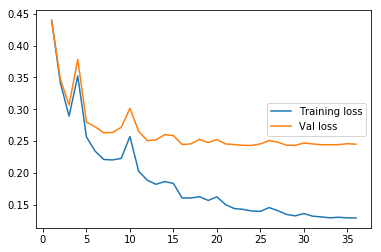

In [93]:
epoch_list = np.linspace(1,36,36)
plt.plot(epoch_list,t_l)
plt.plot(epoch_list,v_l)
plt.legend(['Training loss','Val loss'], loc='center right')
plt.show()

Plot of accuracy:

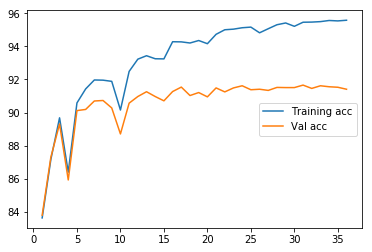

In [94]:
plt.plot(epoch_list,t_a)
plt.plot(epoch_list,v_a)
plt.legend(['Training acc','Val acc'], loc='center right')
plt.show()

"test_model" function:

In [95]:
test_model(X_val,y_val)

Test Loss: 0.27276739478111267
Test Accuracy: 90.85999727249146


Number of parameters in network:

In [68]:
sum(p.numel() for p in model.parameters())

45720